# Project 2 - Forecasting Service Metrics

Authors: Tatiana Barrios, Anisha Anandkrishnan

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import os
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from pandas import concat
import seaborn as sns
import scipy.stats as st
from scipy.fft import fft, ifft
from statsmodels.tsa.ar_model import AutoReg

%matplotlib inline

In [111]:
#NMAE function
def nmae_get(y, y_hat):
    y_av = np.mean(y)
    y_sum = np.sum(np.abs(y - y_hat))
    return y_sum/(len(y)*y_av)

In [157]:
#NMAE for h=0:::10
def nmaes_array(df_test, df_pre, h):
    nmaes = []
    for i in range(0, h+1):
        y_predict_i = df_pre.iloc[:, i]
        y_test_o = df_test.iloc[:, i].to_numpy()
        nmaes.append(nmae_get(y_test_o, y_predict_i))
        
    return nmaes

In [134]:
def future_columns(df, h):
    nv = df.shape[1]
    original_names = df.columns
    col, names = list(), list()
    for i in range(0, h+1):
        col.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (original_names[j])) for j in range(nv)]
        else:
            names += [('%s(t+%d)' % (original_names[j], i)) for j in range(nv)]
    concated_ = concat(col, axis=1)
    concated_.columns = names
    
    #This might bring errors, but i dont know if its better to drop them or to fill them at this point
    concated_.fillna(0, inplace=True)
    return concated_

# Task III - Time series analysis

1. In this task, we apply traditional univariate time-series analysis methods. This means we only consider the target values y(t) of the trace and do not consider the input values x(t)

2. Outliers elimination. Before applying any method, we remove outliers if there are any. Use one of the methods from project 1 (Advanced) to eliminate the outliers.

In [2]:
Y = pd.read_csv('Y.csv')
#Y.index = pd.to_datetime(Y['TimeStamp'])
Y_dropped = Y.drop(labels=["Unnamed: 0", "WritesAvg"], axis=1, inplace=False)

Y_dropped1 = Y.drop(labels=["Unnamed: 0", "TimeStamp", "WritesAvg"], axis=1, inplace=False)

Y_preprocessed = pd.DataFrame()
Y_tmp = preprocessing.StandardScaler().fit_transform(Y_dropped1)
for i, n in enumerate(Y_dropped1):
        Y_preprocessed[n] = Y_tmp[:, i]

In [3]:
Y_preprocessed.head()

,ReadsAvg
0,1.005214
1,1.235772
2,0.589656
3,2.492800
4,0.486148


In [4]:
Y_dropped.head()

,TimeStamp,ReadsAvg
0,2016-11-20 13:28:05,59.1331
1,2016-11-20 13:28:06,59.8588
2,2016-11-20 13:28:08,57.8251
3,2016-11-20 13:28:09,63.8154
4,2016-11-20 13:28:10,57.4993


In [5]:
print(Y_dropped.shape)
print(Y_preprocessed.shape)

(14481, 2)
(14481, 1)


In [6]:
remove = []
for i in Y_preprocessed:
    for j in range(len(Y_preprocessed[i])):
        if j not in remove and abs(Y_preprocessed[i][j]) > 3.5:
            remove.append(j)
Y_clean = Y_dropped.drop(index=remove, axis=0, inplace=False)

print("Number of dropped samples: ", (len(remove)))
%store Y_clean

Number of dropped samples:  135
Stored 'Y_clean' (DataFrame)


In [7]:
Y_clean = Y_clean.reset_index()
Y_clean = Y_clean.drop(Y_clean.columns[0], axis=1)
Y_clean.head()

,TimeStamp,ReadsAvg
0,2016-11-20 13:28:05,59.1331
1,2016-11-20 13:28:06,59.8588
2,2016-11-20 13:28:08,57.8251
3,2016-11-20 13:28:09,63.8154
4,2016-11-20 13:28:10,57.4993


In [8]:
reads = Y_clean['ReadsAvg']

(49.9422, 68.6422)

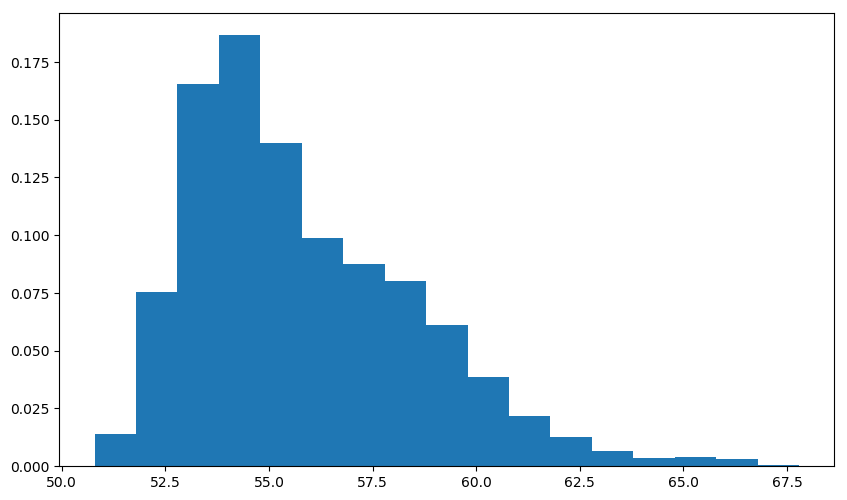

In [9]:
fig, ax1 = plt.subplots(figsize = (10,6), dpi = 100)
mn_point = min(reads)
mx_point = max(reads)
bins = np.arange(mn_point, mx_point + 1, 1)
dens_vals = ax1.hist(reads, density=True, bins=bins, label='Hist')
mn_point, mx_point = plt.xlim()
plt.xlim(mn_point, mx_point)

In [10]:
Y_clean.head()

,TimeStamp,ReadsAvg
0,2016-11-20 13:28:05,59.1331
1,2016-11-20 13:28:06,59.8588
2,2016-11-20 13:28:08,57.8251
3,2016-11-20 13:28:09,63.8154
4,2016-11-20 13:28:10,57.4993


In [11]:
features_file = 'FedCSIS_X.csv'
targets_file = 'FedCSIS_Y.csv'
directory = 'FedCSIS'

fn1 = os.path.join(directory, features_file)
fn2 = os.path.join(directory, targets_file)

Xfed = pd.read_csv(fn1)
Yfed = pd.read_csv(fn2)

In [12]:
Xfed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           1917 non-null   int64  
 1   host1619_/dev/shm    1917 non-null   float64
 2   host1619_cpu_idle    1917 non-null   float64
 3   host1619_cpu_iowait  1917 non-null   float64
 4   host1619_cpu_sys     1917 non-null   float64
 5   host1619_cpu_user    1917 non-null   float64
 6   host1619_memory.0    1917 non-null   float64
 7   host1619_memory.1    1917 non-null   float64
 8   host1619_memory.2    1917 non-null   float64
 9   host1619_memory.3    1917 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 149.9 KB


In [13]:
Yfed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1917 non-null   int64  
 1   host1619_/  1917 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 30.1 KB


In [14]:
Yfed.head()

,Unnamed: 0,host1619_/
0,0,0.025145
1,1,0.036997
2,2,0.048848
3,3,0.014863
4,4,0.020468


In [15]:
Xfed = Xfed.drop(Xfed.columns[0], axis=1)

In [16]:
Yfed = Yfed.drop(Yfed.columns[0], axis=1)

In [17]:
Yfed.head()

,host1619_/
0,0.025145
1,0.036997
2,0.048848
3,0.014863
4,0.020468


In [18]:
hostdata = Yfed['host1619_/']

Text(0.5, 1.0, 'Time series of FedCSIS data')

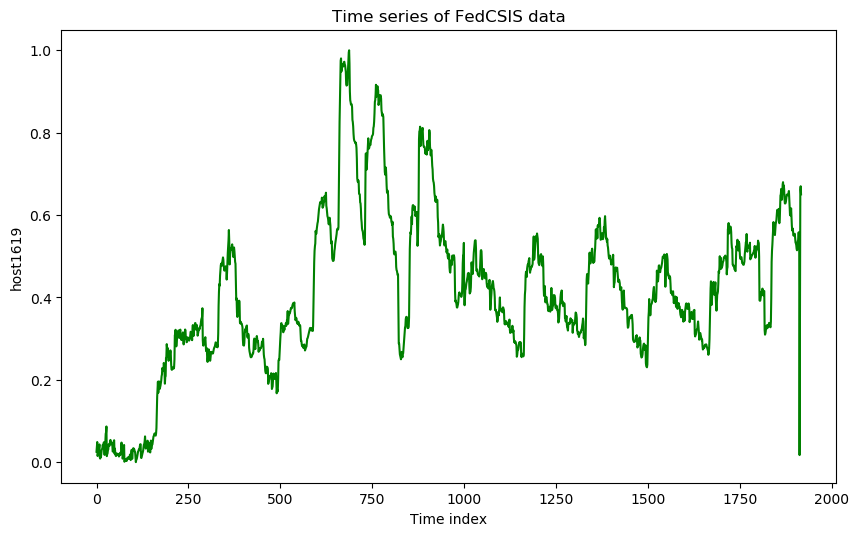

In [19]:
#Time series of this plot
fig_, linep_ = plt.subplots(figsize = (10,6), dpi = 100)
linep_ = sn.lineplot(data=hostdata, color='green')
linep_.set(xlabel='Time index', ylabel='host1619')

linep_.set_title("Time series of FedCSIS data")

In [20]:
fig_.savefig('timesDT1.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Density and histogram for target in FedCSIS data')

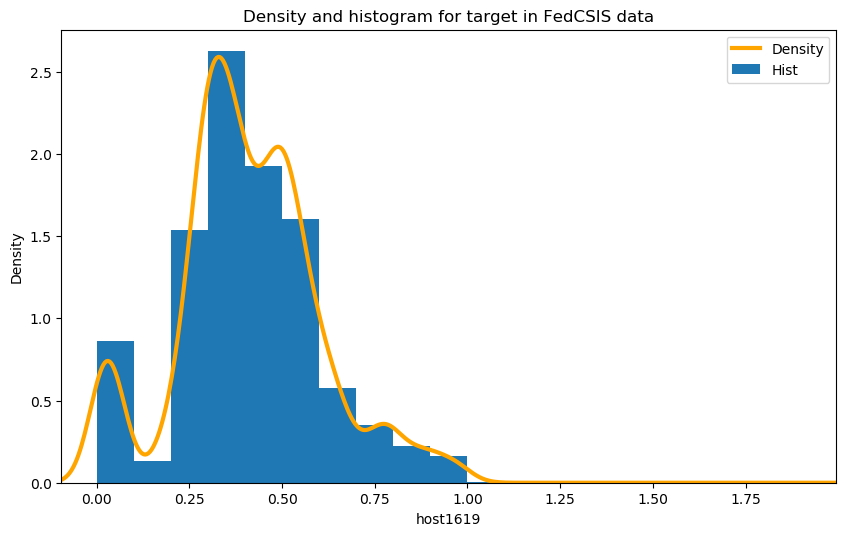

In [21]:
fig, ax1 = plt.subplots(figsize = (10,6), dpi = 100)
mn_point = min(hostdata)
mx_point = max(hostdata)
bins = np.arange(mn_point, mx_point + 1, 0.1)
dens_vals = ax1.hist(hostdata, density=True, bins=bins, label='Hist')
mn_point, mx_point = plt.xlim()
plt.xlim(mn_point, mx_point)

#Kernel density estimation
kde = st.gaussian_kde(hostdata)
kde_x = np.linspace(mn_point, mx_point, 500)
ax1.plot(kde_x, kde.pdf(kde_x), color='orange', label='Density', linewidth=3.0)
plt.legend(loc="upper right")
plt.xlabel('host1619')
plt.ylabel('Density')
plt.title('Density and histogram for target in FedCSIS data')

In [22]:
fig.savefig('densitytargetfcsis.png', dpi=300, bbox_inches='tight')

In [23]:
Xfed_preprocessed = pd.DataFrame()
Xfed_tmp = preprocessing.StandardScaler().fit_transform(Xfed)
for i, n in enumerate(Xfed):
        Xfed_preprocessed[n] = Xfed_tmp[:, i]

In [24]:
Xfed.describe(percentiles=[.25, .95])

,host1619_/dev/shm,host1619_cpu_idle,host1619_cpu_iowait,host1619_cpu_sys,host1619_cpu_user,host1619_memory.0,host1619_memory.1,host1619_memory.2,host1619_memory.3
count,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000
mean,0.342723,0.654299,0.418802,0.359165,0.377096,0.841901,0.484631,0.478202,0.740316
std,0.470492,0.289803,0.300691,0.286012,0.289992,0.133268,0.274356,0.278042,0.192699
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.384615,0.192308,0.200000,0.111111,0.782191,0.229027,0.206778,0.621646
50%,0.000000,0.769231,0.346154,0.200000,0.222222,0.893017,0.447973,0.521411,0.796959
95%,1.000000,0.961538,0.923077,0.800000,0.888889,0.964126,0.897756,0.924681,0.957245
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
#converting Y_dropped to make it of the same form as X_preprocessed
Yfed_new = pd.DataFrame()
Yfed_tmp=Yfed.to_numpy()

for i, n in enumerate(Yfed):
        Yfed_new[n] = Yfed_tmp[:, i]  
# outlier rejection   
remove = []
for i in Xfed_preprocessed:
    for j in range(len(Xfed_preprocessed[i])):
        if j not in remove and abs(Xfed_preprocessed[i][j]) > 3.8:
            remove.append(j)
Xfed_clean = Xfed_preprocessed.drop(labels=remove, axis=0, inplace=False)
Yfed_clean = Yfed_new.drop(labels=remove, axis=0, inplace=False)

print("Number of dropped samples: ", (len(remove)))
%store Xfed_clean
%store Yfed_clean

Number of dropped samples:  19
Stored 'Xfed_clean' (DataFrame)
Stored 'Yfed_clean' (DataFrame)


In [26]:
Xfed_clean.describe(percentiles=[.25, .95])

,host1619_/dev/shm,host1619_cpu_idle,host1619_cpu_iowait,host1619_cpu_sys,host1619_cpu_user,host1619_memory.0,host1619_memory.1,host1619_memory.2,host1619_memory.3
count,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000
mean,0.001693,-0.009222,0.011520,0.011100,-0.014643,0.041939,0.004255,-0.014614,0.004696
std,1.000737,1.000844,0.998366,0.998644,0.991894,0.894879,1.004060,0.993964,0.996482
min,-0.728625,-2.258326,-1.393163,-1.256099,-1.300703,-3.794690,-1.766891,-1.720341,-3.796409
25%,-0.728625,-0.930819,-0.753443,-0.556644,-0.917451,-0.414504,-0.939007,-0.979177,-0.614834
50%,-0.728625,0.396689,-0.241667,-0.556644,-0.534199,0.393279,-0.115470,0.141821,0.305629
95%,1.397364,1.060442,1.677492,1.541718,1.765311,0.917376,1.507685,1.598460,1.129751
max,1.397364,1.193193,1.933380,2.241173,2.148563,1.186637,1.878958,1.877182,1.347969


In [27]:
hostdata_cln = Yfed_clean['host1619_/']

In [28]:
fedcsis_everything = Xfed_clean.join(hostdata_cln) 
gen_corr_mat = fedcsis_everything.corr()
print(gen_corr_mat)

                     host1619_/dev/shm  host1619_cpu_idle  \
host1619_/dev/shm             1.000000           0.073272   
host1619_cpu_idle             0.073272           1.000000   
host1619_cpu_iowait          -0.001780          -0.971436   
host1619_cpu_sys             -0.050581          -0.966673   
host1619_cpu_user            -0.214932           0.581027   
host1619_memory.0             0.202105          -0.484524   
host1619_memory.1            -0.115305          -0.883080   
host1619_memory.2            -0.198455           0.780803   
host1619_memory.3             0.072743          -0.293824   
host1619_/                    0.253803          -0.110171   

                     host1619_cpu_iowait  host1619_cpu_sys  host1619_cpu_user  \
host1619_/dev/shm              -0.001780         -0.050581          -0.214932   
host1619_cpu_idle              -0.971436         -0.966673           0.581027   
host1619_cpu_iowait             1.000000          0.972122          -0.751905   
host

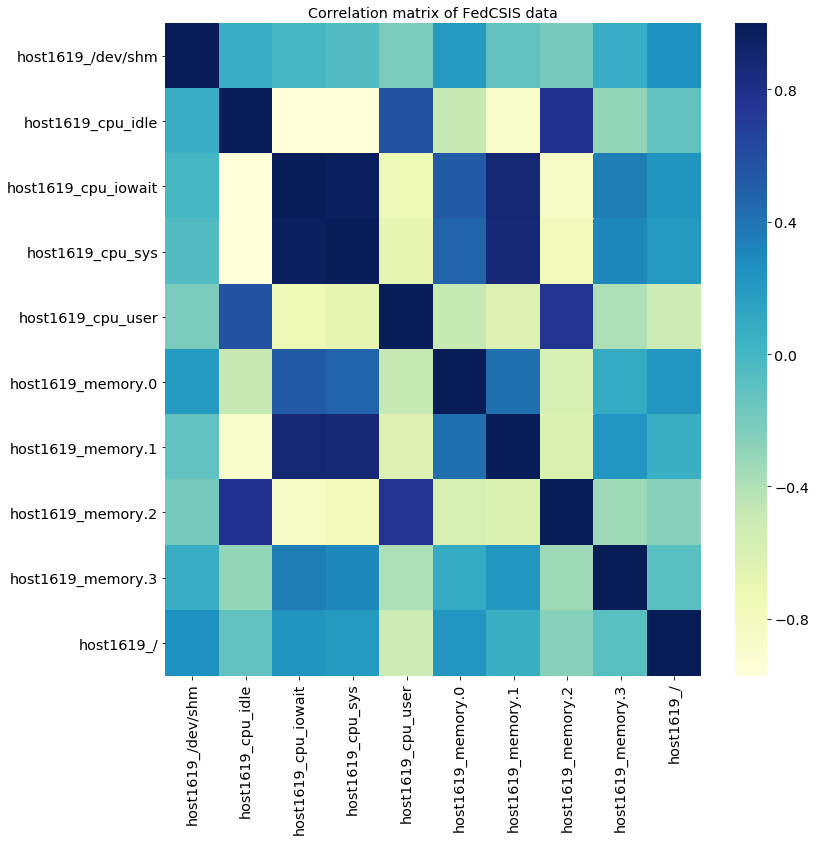

In [29]:
#Heatmap of correlation matrix
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 12),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
heatmaplt = sn.heatmap(gen_corr_mat, cmap="YlGnBu")
heatmaplt.set_title('Correlation matrix of FedCSIS data')
plt.show()

In [101]:
fig = heatmaplt.get_figure()
fig.savefig('corrmat_fedcsis.png', dpi=300, bbox_inches='tight')

3. The auto-correlation function (ACF) computes the correlation of observations in a time series with respect to lag values. Compute the values of this function for the KTH trace and the FedCSIS trace. For each trace, plot the ACF values (correlogram) in two ways.The first plot shows the lag values in the interval l = 0; :::; 100, the second plot shows in the interval l = 0; :::; 4000. The x-axis of the plots shows the lag values and the y-axis shows the correlation coefficients (Pearson correlation) with values between -1 and 1 for negative and positive correlation, respectively.

[Text(0, 0.5, 'Coefficients'), Text(0.5, 0, 'lag')]

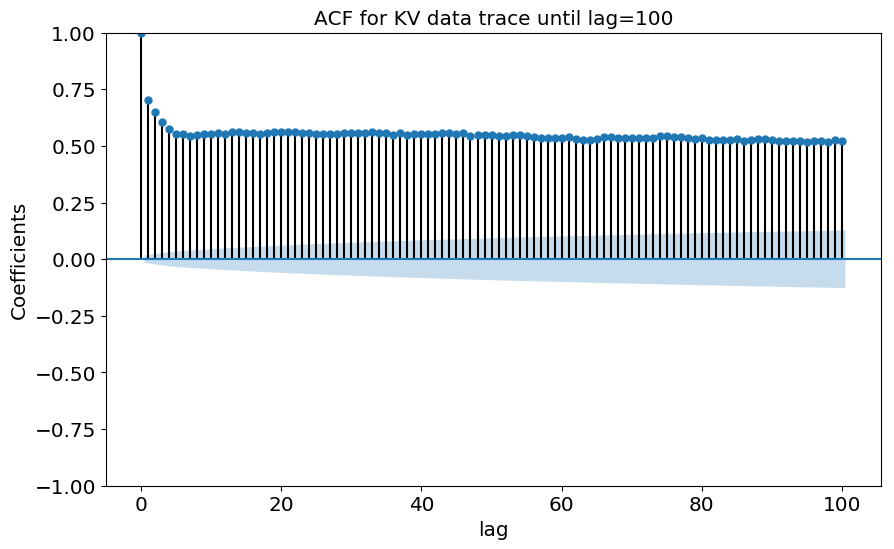

In [102]:
# For the KTH trace (KV_periodic)
fig, plotss = plt.subplots(figsize = (10,6), dpi = 100)

plot_acf(x=Y_clean, lags=100, ax=plotss)
plotss.set(title="ACF for KV data trace until lag=100")
plotss.set(xlabel='lag', ylabel='Coefficients')

In [45]:
fig.savefig('kv_acf100.png', dpi=300, bbox_inches='tight')

[Text(0, 0.5, 'Coefficients'), Text(0.5, 0, 'lag')]

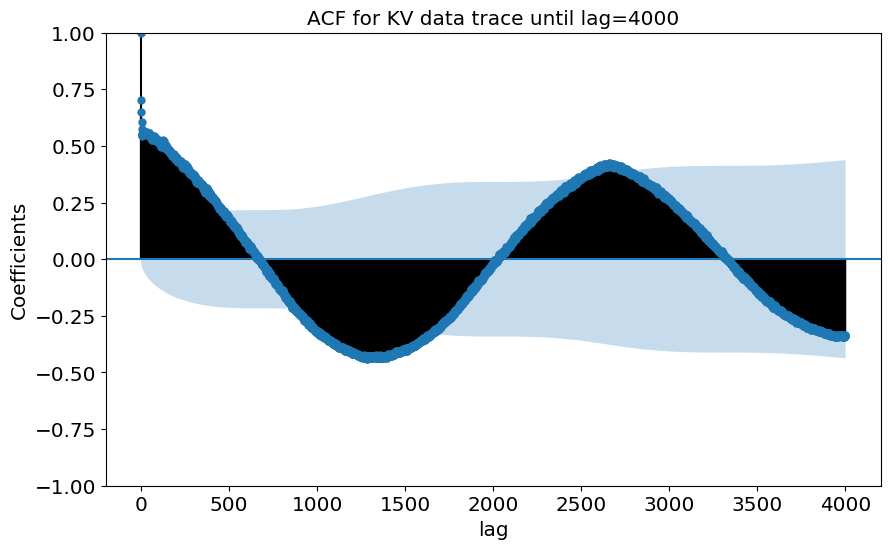

In [103]:
fig, plotss = plt.subplots(figsize = (10,6), dpi = 100)

plot_acf(x=Y_clean, lags=4000, ax=plotss)
plotss.set(title="ACF for KV data trace until lag=4000")
plotss.set(xlabel='lag', ylabel='Coefficients')

In [49]:
fig.savefig('kv_acf4000.png', dpi=300, bbox_inches='tight')

[Text(0, 0.5, 'Coefficients'), Text(0.5, 0, 'lag')]

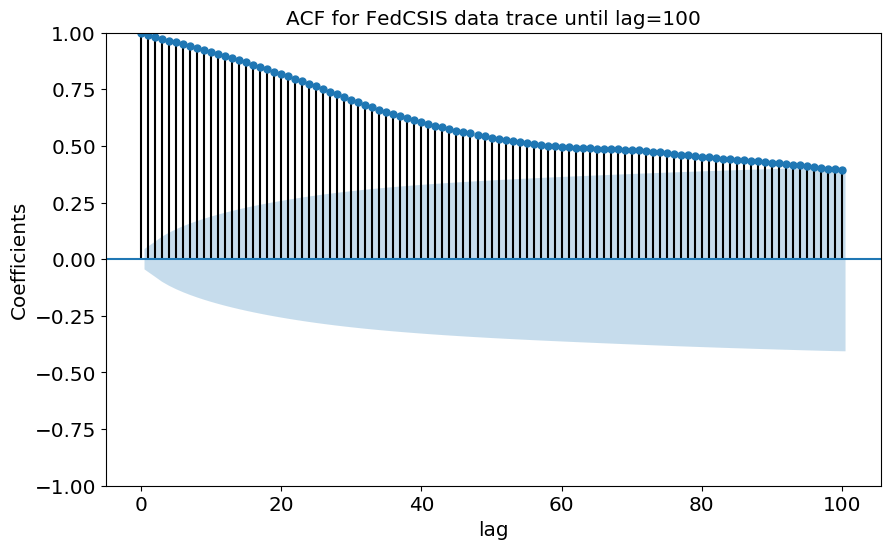

In [104]:
# For the FedCSIS trace
fig, plotss = plt.subplots(figsize = (10,6), dpi = 100)

plot_acf(x=Yfed_clean, lags=100, ax=plotss)
plotss.set(title="ACF for FedCSIS data trace until lag=100")
plotss.set(xlabel='lag', ylabel='Coefficients')

In [105]:
fig.savefig('fed_acf100.png', dpi=300, bbox_inches='tight')

In [106]:
Yfed_clean.shape

(1898, 1)

[Text(0, 0.5, 'Coefficients'), Text(0.5, 0, 'lag')]

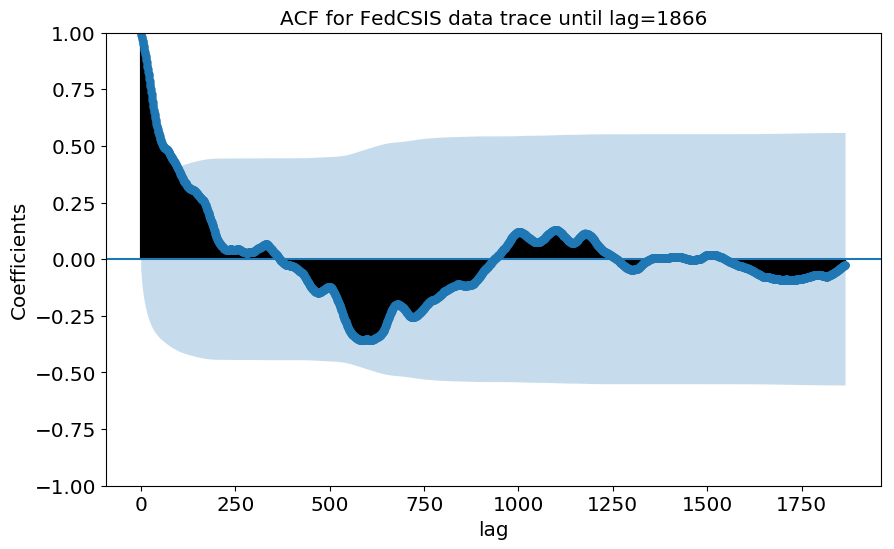

In [107]:
fig, plotss = plt.subplots(figsize = (10,6), dpi = 100)

plot_acf(x=Yfed_clean, lags=1866, ax=plotss)
plotss.set(title="ACF for FedCSIS data trace until lag=1866")
plotss.set(xlabel='lag', ylabel='Coefficients')

In [108]:
fig.savefig('fed_acf4000.png', dpi=300, bbox_inches='tight')

# Task IV - Time series forecasting

1. Fit an Autoregression (AR) model to the KTH time series. Perform forecasting using the AR model, which formulates the next step in the sequence as a linear function of the observations at previous time steps. The method is suitable for time series without trend and seasonal components. Evaluate the method for the AR model parameter p = 1; :::; 10.

In [30]:
Y_clean.head()

,TimeStamp,ReadsAvg
0,2016-11-20 13:28:05,59.1331
1,2016-11-20 13:28:06,59.8588
2,2016-11-20 13:28:08,57.8251
3,2016-11-20 13:28:09,63.8154
4,2016-11-20 13:28:10,57.4993


Text(0.5, 1.0, 'Time series of reads data (clean)')

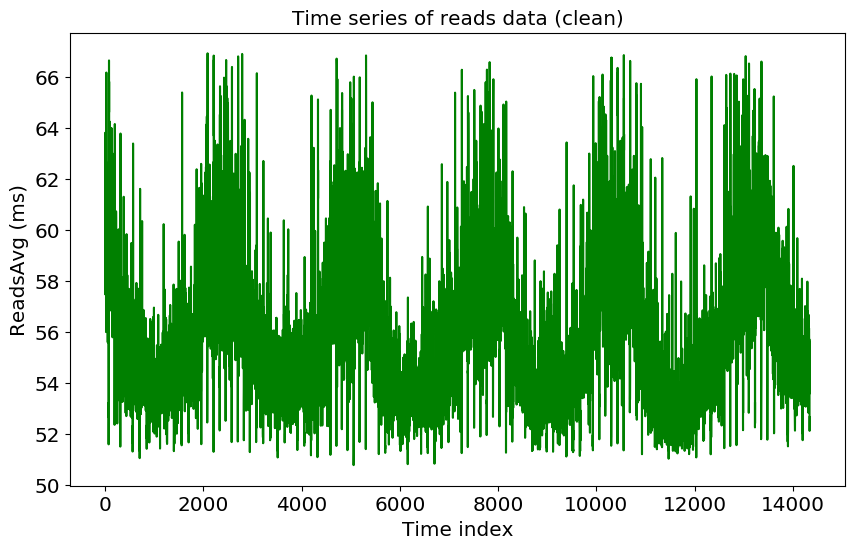

In [31]:
# This data is seasonal, so we want to remove the seasonality before implementing AR or MA
# Before removing seasonality, we need to find out the period, for that we use fft
#Time series of this plot (for finding the period)
fig_, linep_ = plt.subplots(figsize = (10,6), dpi = 100)

linep_ = sn.lineplot(data=Y_clean, x=Y_clean.index, y="ReadsAvg", color='green')
linep_.set(xlabel='Time index', ylabel='ReadsAvg (ms)')

linep_.set_title("Time series of reads data (clean)")

[Text(0, 0.5, 'ReadsAvg (ms)'), (0, 2400), Text(0.5, 0, 'Time index')]

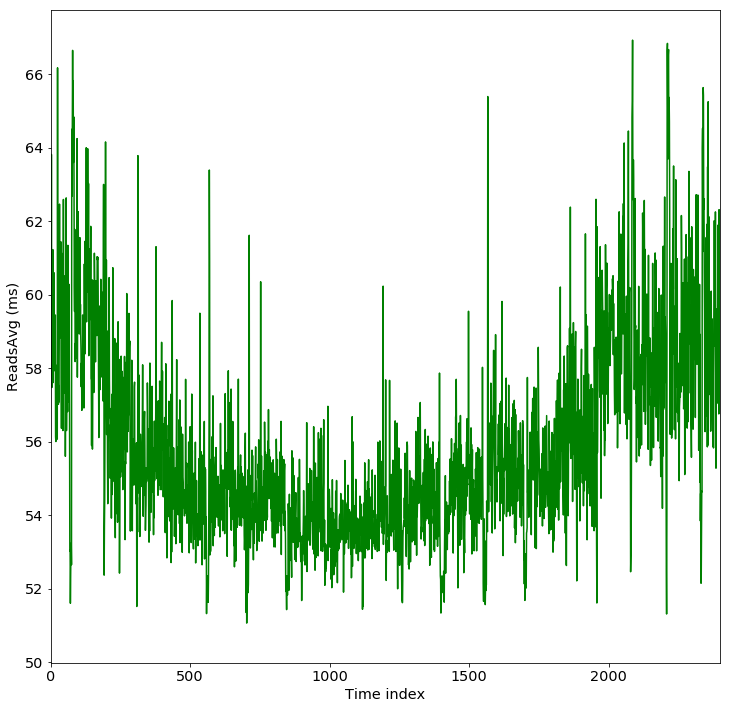

In [32]:
linep_ = sn.lineplot(data=Y_clean, x=Y_clean.index, y="ReadsAvg", color='green')
linep_.set(xlabel='Time index', ylabel='ReadsAvg (ms)', xlim=(0,2400))


[Text(0, 0.5, 'ReadsAvg (ms)'), (2400, 4800), Text(0.5, 0, 'Time index')]

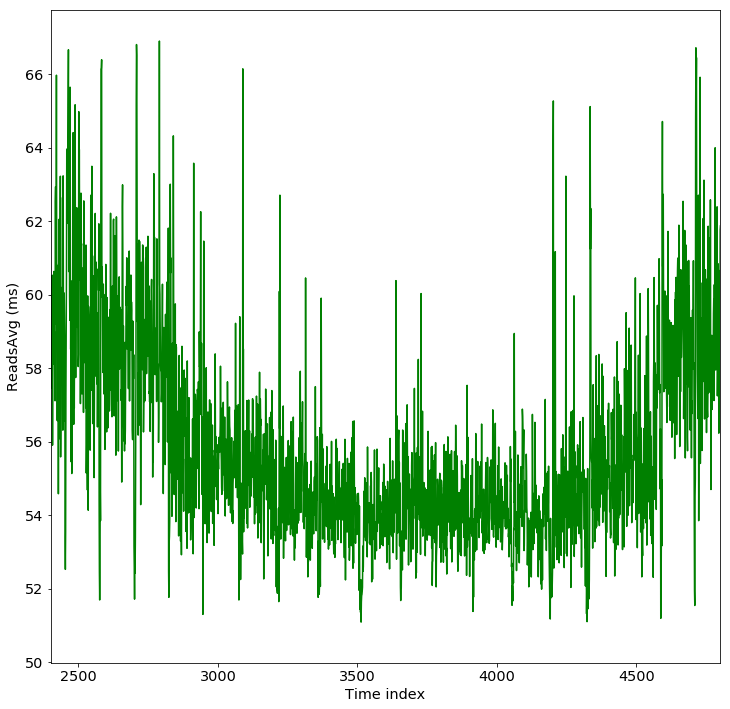

In [33]:
linep_ = sn.lineplot(data=Y_clean, x=Y_clean.index, y="ReadsAvg", color='green')
linep_.set(xlabel='Time index', ylabel='ReadsAvg (ms)', xlim=(2400, 4800))

In [138]:
#Period is around index 2400. Let's use Seasonal Adjustment with Modeling (because it allows us to have a trial and error method)
# I tried with periods around 2400, it seems like the best fit is 2570 roughly

In [35]:
Y_clean_ = Y_clean.drop(labels=["TimeStamp"], axis=1, inplace=False)

In [88]:
period = 2570
X = [i%period for i in range(0, len(reads))]
degree = 4
coef = np.polyfit(X, reads, degree)
print('Coefficients: %s' % coef)

Coefficients: [-1.45248939e-12  7.41091436e-09 -8.61077666e-06 -2.25700658e-03
  5.89372188e+01]


[Text(0, 0.5, 'ReadsAvg (ms)'),
 Text(0.5, 0, 'Time index'),
 Text(0.5, 1.0, 'Seasonality curve')]

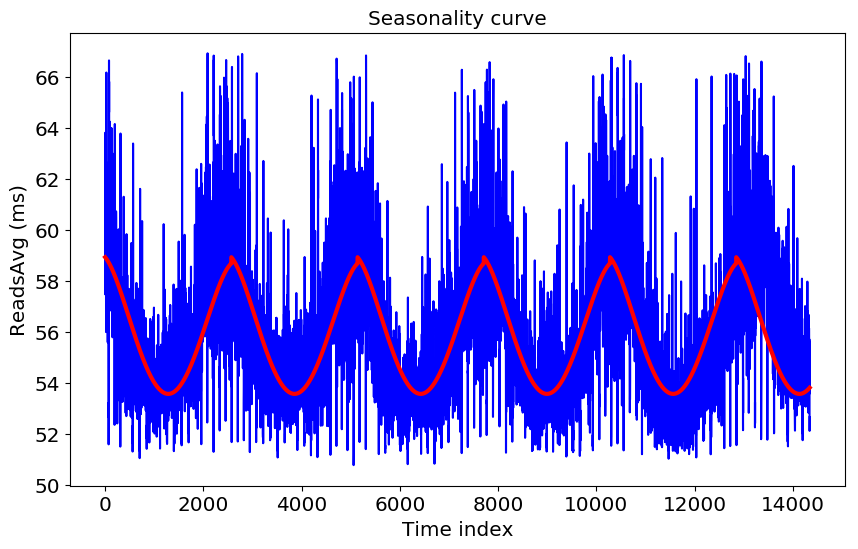

In [89]:
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
fig_, linep_ = plt.subplots(figsize = (10,6), dpi = 100)

linep_ = sn.lineplot(data=reads, color='blue')
plt.plot(curve, color='red', linewidth=3)
linep_.set(xlabel='Time index', ylabel='ReadsAvg (ms)', title="Seasonality curve")

In [90]:
fig_.savefig('seasonality.png', dpi=300, bbox_inches='tight')

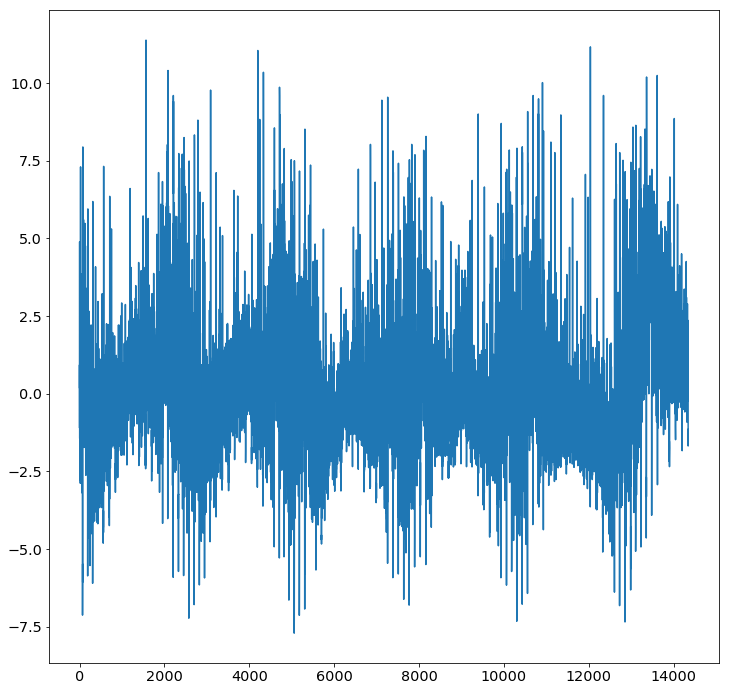

In [91]:
#Removing seasonality
diff = list()
for i in range(len(reads)):
    read = reads[i] - curve[i]
    diff.append(read)
plt.plot(diff)
plt.show()

In [92]:
Y_clean_ws = pd.DataFrame(diff, columns =['ReadsAvg'], dtype = float) 

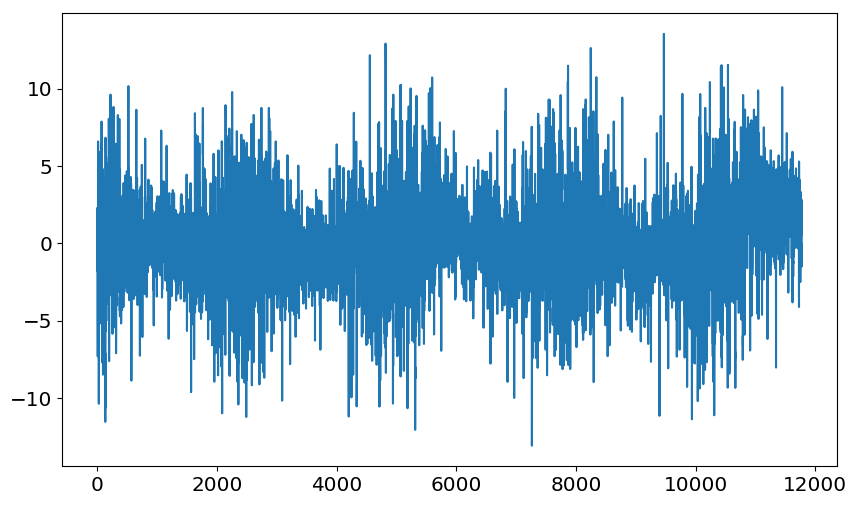

In [124]:
# Seasonal Adjustment with Differencing (it makes the first period unavailable for modeling)
diff_ = list()
for i in range(period, len(reads)):
    value = reads[i] - reads[i - period]
    diff_.append(value)
fig_, linep_ = plt.subplots(figsize = (10,6), dpi = 100)
plt.plot(diff_)
plt.show()

In [125]:
Y_clean_ws_ = pd.DataFrame(diff_, columns =['ReadsAvg'], dtype = float) 

In [130]:
Y_clean_ws_.shape

(11776, 1)

In [131]:
#Splitting train and test
Y_train, Y_test = train_test_split(Y_clean_ws_, test_size=0.3, shuffle = False)
print(Y_train.shape,"(70% of the samples in training set)")
Y_train = Y_train.sort_index(axis = 0)
Y_test = Y_test.sort_index(axis = 0)

(8243, 1) (70% of the samples in training set)


In [140]:
Y_new_test = future_columns(Y_test, 10)
h = 10

In [148]:
#Data is non seasonal now
#p=1, h=10 using rolling forecast (AR model)
history = Y_train.values
test = Y_test.values
predictions = list()
for t in range(len(test)):
    model_fit = AutoReg(history, lags=1, seasonal=False).fit()
    output = model_fit.forecast(steps=11)
    predictions.append(output)
    obs = test[t]
    history = np.append(history, obs)

In [154]:
yin = Y_new_test.index
ycol =Y_new_test.columns
Y_pred = pd.DataFrame(predictions, columns = ycol, index=yin)

In [155]:
Y_pred.head()

,ReadsAvg(t),ReadsAvg(t+1),ReadsAvg(t+2),ReadsAvg(t+3),ReadsAvg(t+4),ReadsAvg(t+5),ReadsAvg(t+6),ReadsAvg(t+7),ReadsAvg(t+8),ReadsAvg(t+9),ReadsAvg(t+10)
8243,-1.064781,-0.481191,-0.246264,-0.151693,-0.113624,-0.098298,-0.092129,-0.089646,-0.088646,-0.088244,-0.088082
8244,-0.280536,-0.165425,-0.119089,-0.100438,-0.092930,-0.089907,-0.088691,-0.088201,-0.088004,-0.087925,-0.087893
8245,2.531358,0.967134,0.337562,0.084171,-0.017815,-0.058862,-0.075383,-0.082032,-0.084709,-0.085786,-0.086219
8246,0.637786,0.204843,0.030629,-0.039474,-0.067683,-0.079034,-0.083602,-0.085440,-0.086179,-0.086477,-0.086597
8247,-0.057956,-0.075200,-0.082138,-0.084930,-0.086054,-0.086506,-0.086688,-0.086761,-0.086790,-0.086802,-0.086807


In [158]:
nmaes_l1 = nmaes_array(Y_new_test, Y_pred, h)

In [166]:
d = {'nmaes_l1': nmaes_l1}
nmaes_df = pd.DataFrame(data=d)

In [167]:
nmaes_df

,nmaes_l1
0,5.083653
1,5.540394
2,5.745703
3,5.856287
4,5.893363
5,5.958116
6,5.966363
7,5.969648
8,5.973169
9,5.973864


In [170]:
#p=2 onwards, h=10 using rolling forecast 
for p in range(2,11):
    history = Y_train.values
    test = Y_test.values
    predictions = list()
    for t in range(len(test)):
        model_fit = AutoReg(history, lags=p, seasonal=False).fit()
        output = model_fit.forecast(steps=h+1)
        predictions.append(output)
        obs = test[t]
        history = np.append(history, obs)
    Y_pred_ = pd.DataFrame(predictions, columns = ycol, index=yin)
    nme = nmaes_array(Y_new_test, Y_pred_, h)
    nmaes_df['nmaes_l'+str(p)] = nme
    print(p)


2
3
4
5
6
7
8
9
10


In [171]:
nmaes_df

,nmaes_l1,nmaes_l2,nmaes_l3,nmaes_l4,nmaes_l5,nmaes_l6,nmaes_l7,nmaes_l8,nmaes_l9,nmaes_l10
0,5.083653,4.967204,4.910916,4.906242,4.908569,4.899541,4.896369,4.858105,4.841652,4.831445
1,5.540394,5.303803,5.224027,5.216180,5.218775,5.202564,5.195335,5.144844,5.116710,5.097856
2,5.745703,5.494644,5.390465,5.379506,5.383454,5.358051,5.347163,5.283182,5.246192,5.216102
3,5.856287,5.674487,5.585267,5.568970,5.574342,5.541045,5.528443,5.449018,5.405956,5.368418
4,5.893363,5.770940,5.695305,5.682346,5.687825,5.648664,5.634102,5.543671,5.494639,5.452054
5,5.958116,5.882663,5.823559,5.812060,5.815596,5.765595,5.749109,5.647673,5.594110,5.548705
6,5.966363,5.920362,5.874803,5.864920,5.867845,5.827809,5.807054,5.697322,5.638747,5.589814
7,5.969648,5.938212,5.902231,5.894219,5.897090,5.861500,5.843934,5.716120,5.652039,5.600536
8,5.973169,5.954195,5.928057,5.921766,5.923710,5.894674,5.879836,5.777906,5.701013,5.642815
9,5.973864,5.962603,5.944248,5.939389,5.940571,5.917799,5.905526,5.817662,5.754914,5.684394


2. Fit a Moving Average (MA) model to the KTH time series. Perform forecasting using the MA model, which formulates the next step in the sequence as a linear function of the residual errors from a meanprocess at previous time steps. Note that MA is different from calculating the moving average of a time series. The method is suitable for time series without trend and seasonal components. Evaluate the method for the model parameter q = 1; :::; 10.

In [174]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
#Data is non seasonal now
#q=1, h=10 using rolling forecast (MA model)
history = Y_train.values
test = Y_test.values
predictions = list()
for t in range(len(test)):
    model_fit = ARIMA(history, order=(0,0,1), trend='n').fit()
    output = model_fit.forecast(steps=11)
    predictions.append(output)
    obs = test[t]
    history = np.append(history, obs)

In [ ]:
Y_pred = pd.DataFrame(predictions, columns = ycol, index=yin)

In [ ]:
nmaes_l1 = nmaes_array(Y_new_test, Y_pred, h)
d = {'nmaes_l1': nmaes_l1}
nmaes_df_MA = pd.DataFrame(data=d)

In [ ]:
nmaes_df_MA

In [ ]:
#q=2 onwards, h=10 using rolling forecast 
for q in range(2,11):
    history = Y_train.values
    test = Y_test.values
    predictions = list()
    for t in range(len(test)):
        model_fit = ARIMA(history, order=(0,0,q), trend='n').fit()
        output = model_fit.forecast(steps=11)
        predictions.append(output)
        obs = test[t]
        history = np.append(history, obs)
    Y_pred_ = pd.DataFrame(predictions, columns = ycol, index=yin)
    nme = nmaes_array(Y_new_test, Y_pred_, h)
    nmaes_df_MA['nmaes_l'+str(q)] = nme
    print(q)